Для прогнозирования используются данные о покупках юзеров за период 2021 года. Всего доступно больше 2 млн. строк.

Флаг оттока проставляется, если после покупки юзера прошло больше 45 дней.

Поведение юзера описывается историей его покупок, суммой чека и размером скидки к чеку. В компании действует программа лояльности, участвуя в которой юзеры получают скидку на любую покупку и могут получать дополнительные скидки по разным промо-акциями.

Описание данных:
data.csv
* `'clnt_ID'` - уникальный айди юзера, str
* `'timestamp'` - дата и время совершения покупки, datetime
* `'gest_Sum'` - сумма покупки, float
* `'gest_Discount'` - сумма скидки, float

target.csv
* `'clnt_ID'` - уникальный айди юзера, str
* `'target'` - флаг оттока, int: 1 если юзер ушел в отток | 0 если НЕ отток

# Что здесь можно сделать? - Заметки
**Нужно помнить, что по сути это тайм серия.**
Т.е. я предполагаю, что клиент покупает, покупает, покупает, потом фигак и перестал покупать. Один клиент - один вектор.
А тут куча вектором принадлежат одному клиенту. 

Т.е. я бы даже сказал, что в том виде в котором оно есть, модель особо-то ничего не найдет. Как она сможет по дате, сумме покупки и скидке предсказать уйдет человек или нет, не зная его истории?

**Что может говорить, что клиент собрался уйти и не вернуться?**
Т.е. гипотетически что может говорить о том, что клиент собирается уйти и не вернуться?
1. Увеличивается интервал между покупками от покупки к покупке. Типа 1 день, потом 2, потом 5 и т.д.
2. Как-то изменяется объем чека (уменьшается, увеличивается?) 
3. Как-то меняется ассортимент (типа вот он покупал одно и тоже, а тут вдруг перестал покупать одно и тоже (испортился товар на его вкус) и он либо сразу ушел, либо попробовал другое и остался, либо попробовал другое - ему не понравилось - ушел

**Как должен работать предикт? Какие данные должны поступать на вход?**
Это видимо тоже относится к тому, что это своего рода таймсерия

**Если сейчас дать модели на вход просто дату, сумму чека и скидку...**
То она будет пытаться предсказать отток исключительно по дате, сумме чеку и скидке - врядли у нее что-то получится взразумительное.


**Сумма в месяц стабильна для юзера, а отклонение может указывать на отток**
По результатам уже проведенного анализа есть такой вывод:
сумма, которую готов тратить юзер в месяц,  достаточна стабильна и слабо меняется со временем. Потратив в этом месяце больше обычного, юзер скорее всего в следующем не будет покупать;

По каждому клиенту взять средний чек, каким-то образом определить порог отклонения от этого среднего чека и посмотреть насколько факт этого отклонения коррелирует с оттоком. Может это будет хорошая фича. Но проблема в том, что для предсказания не достаточно 

In [29]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 100)

In [3]:
df = pd.read_csv('data/data.csv')
df_target = pd.read_csv('data/target.csv')

In [4]:
display(df.head())
df_target.head()

,clnt_ID,timestamp,gest_Sum,gest_Discount
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-02 09:09:17.060,900.000000,300.0
1,8DA65A37-C1D0-41D4-98E1-AB6C5BF1367F,2021-01-02 09:12:24.850,165.000000,55.0
2,26ACF3C8-25C8-4345-ABC2-33DA15EA6454,2021-01-02 09:38:21.643,800.500000,25.5
3,0F77DDB3-A9A7-44BE-AAAB-9DF59B66A695,2021-01-02 09:45:17.793,580.000000,0.0
4,F16BCF77-FA5A-4093-B7E3-FA86E2B1EA31,2021-01-02 09:59:50.453,148.899994,3.1


,clnt_ID,target
0,000070A8-DB9E-4AB7-8C4D-6169D4AEBB2A,1
1,00007EB0-6331-438E-A917-E9840C260876,0
2,0000993D-A30E-4233-AB3F-D368D9A0D2C4,1
3,0000A724-7BC5-408F-9F16-6CC3AB16322F,0
4,0000B90C-56DE-43C2-A213-624AFBE36DB2,0


### Предобработка датасетов

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2371635 entries, 0 to 2371634
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   clnt_ID        object 
 1   timestamp      object 
 2   gest_Sum       float64
 3   gest_Discount  float64
dtypes: float64(2), object(2)
memory usage: 72.4+ MB


In [6]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255109 entries, 0 to 255108
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   clnt_ID  255109 non-null  object
 1   target   255109 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.9+ MB


* timestamp - object, а не datetime

Проверим на дубликаты и пропуски.

In [7]:
df.isna().sum()

clnt_ID          0
timestamp        0
gest_Sum         0
gest_Discount    0
dtype: int64

Пропусков нет.

In [8]:
df.duplicated().sum()

129

Есть дубликаты, посмотрим на них.

In [9]:
df.loc[df.duplicated(keep=False)]

,clnt_ID,timestamp,gest_Sum,gest_Discount
639,1FA367BD-8E07-437E-AB6A-009D53533128,2021-01-02 12:00:00.000,982.200012,0.000000
663,1FA367BD-8E07-437E-AB6A-009D53533128,2021-01-02 12:00:00.000,982.200012,0.000000
85786,3319362D-F6AD-498B-9B53-F59D0418915E,2021-01-14 14:00:00.000,1189.000000,0.000000
85787,3319362D-F6AD-498B-9B53-F59D0418915E,2021-01-14 14:00:00.000,1189.000000,0.000000
133279,A145C6F8-EDCB-47B1-BF5D-B328F6AF97CA,2021-01-20 16:00:00.000,0.000000,0.000000
...,...,...,...,...
2165277,E99EFF35-01BE-49A9-8F61-641F752051E5,2021-11-08 15:00:00.000,0.000000,0.000000
2174627,1A4C0239-A7AB-4188-84DB-8F52FBF6E13C,2021-11-10 11:00:00.000,282.239990,37.759998
2174629,1A4C0239-A7AB-4188-84DB-8F52FBF6E13C,2021-11-10 11:00:00.000,282.239990,37.759998
2198034,C9D86AF9-373C-4531-92A4-8FC752DD5D75,2021-11-14 12:00:00.000,0.000000,0.000000


Удалим дубликаты.

In [10]:
df = df.drop_duplicates()

In [11]:
df.duplicated().sum()

0

Дубликаты удалили.

Объединим датасеты.

In [14]:
df_full = df.merge(df_target,on='clnt_ID')

In [22]:
df_full.head()

,clnt_ID,timestamp,gest_Sum,gest_Discount,target
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-02 09:09:17.060,900.000000,300.000000,0
1,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-07 17:09:04.120,393.700012,131.300003,0
2,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-09 11:49:13.163,817.500000,272.500000,0
3,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-11 18:38:07.737,337.500000,112.500000,0
4,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-12 14:53:53.847,180.000000,60.000000,0


In [15]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2371506 entries, 0 to 2371505
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   clnt_ID        object 
 1   timestamp      object 
 2   gest_Sum       float64
 3   gest_Discount  float64
 4   target         int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 108.6+ MB


In [16]:
df_full.isna().sum()

clnt_ID          0
timestamp        0
gest_Sum         0
gest_Discount    0
target           0
dtype: int64

### EDA

Посмотрим кол-во уникальный айдишников.

In [12]:
display(df['clnt_ID'].nunique())
df_target['clnt_ID'].nunique()

255109

255109

255109 клиентов. При этом в датасете с таргетом тоже 255109 записей. Значит все верно.

Посмотрим сколько из них с флагом.

In [13]:
df_target['target'].value_counts()

0    128857
1    126252
Name: target, dtype: int64

Примерно одинаково. Дисбаланса классов нет.

Проверим, что все правильно смержилось.

In [27]:
df_full.loc[df_full['target']==0,'clnt_ID'].nunique()

128857

In [26]:
df_full.loc[df_full['target']==1,'clnt_ID'].nunique()

126252

Да, кол-во уникальных айдишников в каждом классе осталось прежним.

Посмотрим сколько заказов (строк) приходится на каждый класс.

0    1699701
1     671805
Name: target, dtype: int64

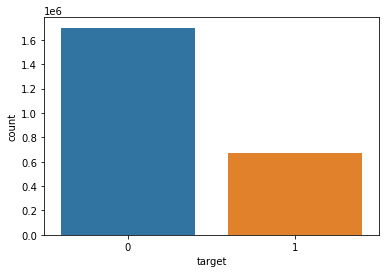

In [32]:
display(df_full['target'].value_counts())
sns.countplot(x='target',data=df_full)
plt.show()

Тут мы видим сразу, что те, кто уходят, значительно меньше раз совершали покупки.

<AxesSubplot:xlabel='target', ylabel='gest_Sum'>

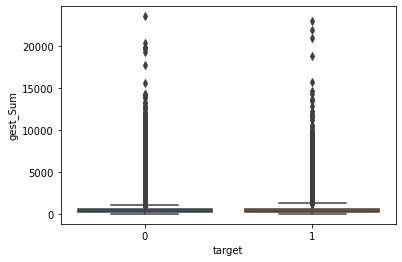

In [35]:
# sns.countplot(x='target',hue='gest_Sum',data=df_full)
sns.boxplot(x="target", y="gest_Sum",
#             hue="smoker", palette=["m", "g"],
            data=df_full)